# Titanic dataset predictions

-> https://www.kaggle.com/competitions/titanic/overview can be used to see an overview of the data

## Todo

- read the overview and define research questions

- load in the data

- perform at least 3 examples of EDA (Visualisations that are relivant to the problem)

- train tune and ensemble a machine learning model 

- share it with ross :) 

# Challenge 

The competition is simple: use machine learning to create a model that predicts which passengers survived the Titanic shipwreck.

Quesitons I would like to answer

Who will survive?
What factors are the strongest indicators of survival? (Class - Sex - Age?)

*see below for an example of an output that could be submitted* 


# Reading in the training and test sets

In [1]:
#A range of python packages
import pandas as pd
import numpy as np
import warnings
import re
import string
import matplotlib.pyplot as plt
import pickle
from sklearn import preprocessing
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve,accuracy_score,\
precision_score, recall_score, f1_score, mean_squared_error
from sklearn.model_selection import cross_val_score
import seaborn as sns
%matplotlib inline
warnings.filterwarnings('ignore')

### Custom functions

from data_cleaning import drop_df_cols, visualise_missing_values

In [2]:
example_output_df = pd.read_csv('titanic/gender_submission.csv')
example_output_df

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [3]:
train_df = pd.read_csv('titanic/train.csv')
test_df = pd.read_csv('titanic/test.csv') # does not contain a 'survived' column
train_df.head()
# sibsp == number of siblings / spouses aboard the Titanic
# Parch == number of parents / children aboard 


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Steps to clean the data
- Dropping Columns we don't need
- Finding missing data
- Create Age groups - Young Middle and Old

In [4]:
drop_df_cols(train_df, "Name", "Ticket", 'Cabin',"Embarked","Fare")
drop_df_cols(test_df, "Name", "Ticket", 'Cabin',"Embarked","Fare")
train_df['Sex'].replace(['female','male'],[0,1],inplace=True)
test_df['Sex'].replace(['female','male'],[0,1],inplace=True)
train_df

----- Droped ['Name', 'Ticket', 'Cabin', 'Embarked', 'Fare']
----- Droped ['Name', 'Ticket', 'Cabin', 'Embarked', 'Fare']


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch
0,1,0,3,1,22.0,1,0
1,2,1,1,0,38.0,1,0
2,3,1,3,0,26.0,0,0
3,4,1,1,0,35.0,1,0
4,5,0,3,1,35.0,0,0
...,...,...,...,...,...,...,...
886,887,0,2,1,27.0,0,0
887,888,1,1,0,19.0,0,0
888,889,0,3,0,NaN,1,2
889,890,1,1,1,26.0,0,0


In [5]:
# Dataset stats
train_df.describe()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch
count,891.000000,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,0.647587,29.699118,0.523008,0.381594
std,257.353842,0.486592,0.836071,0.477990,14.526497,1.102743,0.806057
min,1.000000,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,0.000000,20.125000,0.000000,0.000000
50%,446.000000,0.000000,3.000000,1.000000,28.000000,0.000000,0.000000
75%,668.500000,1.000000,3.000000,1.000000,38.000000,1.000000,0.000000
max,891.000000,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000


Blue is missing, Red is not missing
number of NaN cols:  PassengerId      0
Survived         0
Pclass           0
Sex              0
Age            177
SibSp            0
Parch            0
dtype: int64


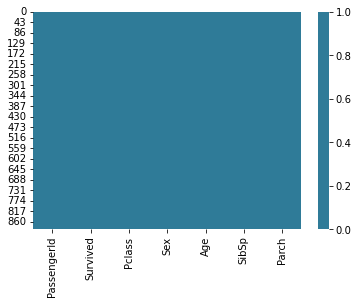

In [6]:
visualise_missing_values(train_df)

Blue is missing, Red is not missing
number of NaN cols:  PassengerId     0
Pclass          0
Sex             0
Age            86
SibSp           0
Parch           0
dtype: int64


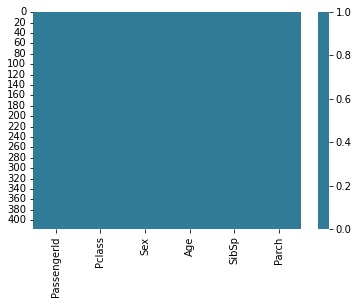

In [7]:
visualise_missing_values(test_df)

In [8]:
test_df = test_df[test_df['Age'].notna()]
train_df = train_df[train_df['Age'].notna()]

In [12]:
# Creating Age groups
train_df['AgeBand'] = pd.cut(train_df['Age'], 5)
test_df['AgeBand'] = pd.cut(test_df['Age'], 5)
train_df['AgeBand'].value_counts()

(16.336, 32.252]    346
(32.252, 48.168]    188
(0.34, 16.336]      100
(48.168, 64.084]     69
(64.084, 80.0]       11
Name: AgeBand, dtype: int64

<AxesSubplot:xlabel='Age', ylabel='Survived'>

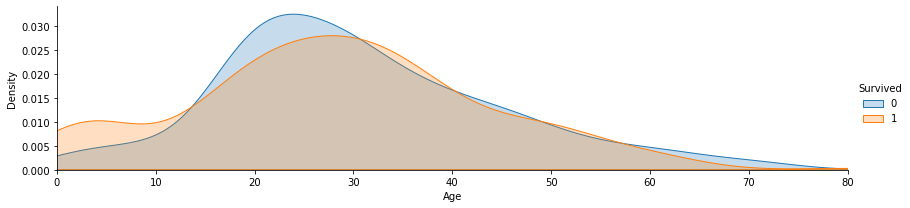

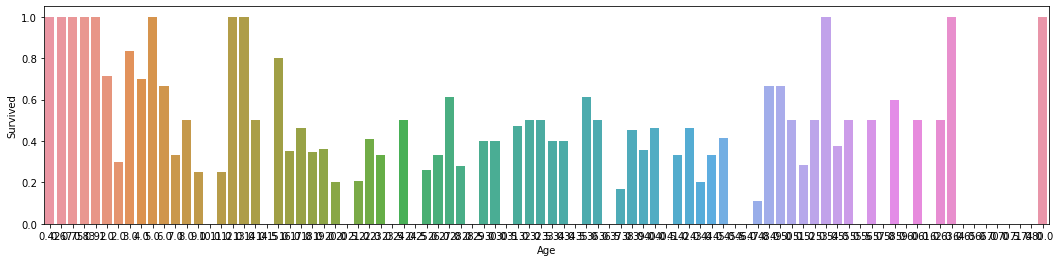

In [13]:
facet = sns.FacetGrid(train_df, hue="Survived",aspect=4)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, train_df['Age'].max()))
facet.add_legend()

# average survived passengers by age
fig, axis1 = plt.subplots(1,1,figsize=(18,4))
average_age = train_df[["Age", "Survived"]].groupby(['Age'],as_index=False).mean()
sns.barplot(x='Age', y='Survived', data=average_age)

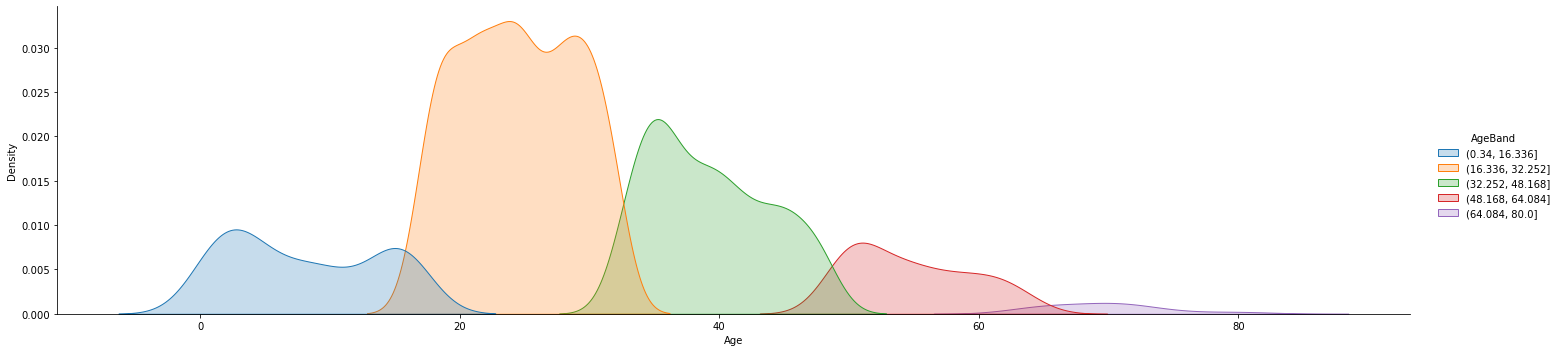

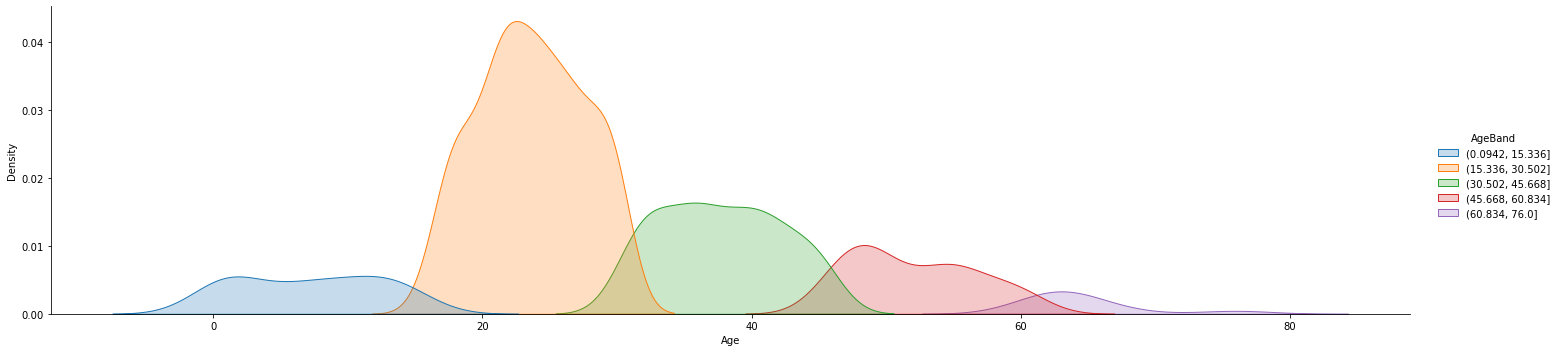

In [14]:
sns.displot(train_df, x="Age", hue='AgeBand', aspect= 4, kind="kde", fill=True)
sns.displot(test_df, x="Age", hue='AgeBand', aspect= 4, kind="kde", fill=True)

In [15]:
train_df[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,"(0.34, 16.336]",0.550000
1,"(16.336, 32.252]",0.369942
2,"(32.252, 48.168]",0.404255
3,"(48.168, 64.084]",0.434783
4,"(64.084, 80.0]",0.090909


In [ ]:
#train_df.drop('Age',inplace=True, axis=1)
#test_df.drop('Age',inplace=True, axis=1)
#train_df

In [16]:
train_df['Survived'].value_counts()

0    424
1    290
Name: Survived, dtype: int64

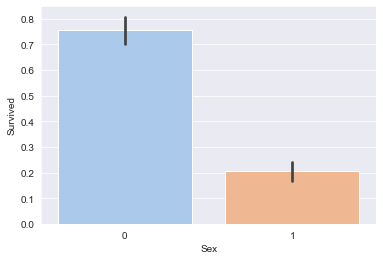

In [17]:
sns.set_palette("pastel")
sns.set_style("darkgrid")
sns.barplot(x = "Sex", y = "Survived", data = train_df)
plt.show()

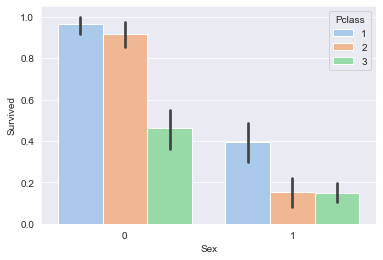

In [18]:
sns.barplot(x = "Sex", y = "Survived", hue = "Pclass", data = train_df)
plt.show()

In [19]:
train_df.groupby('Sex').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch
Sex,,,,,,
0,440.199234,0.754789,2.065134,27.915709,0.639847,0.708812
1,453.412804,0.205298,2.335541,30.726645,0.439294,0.271523


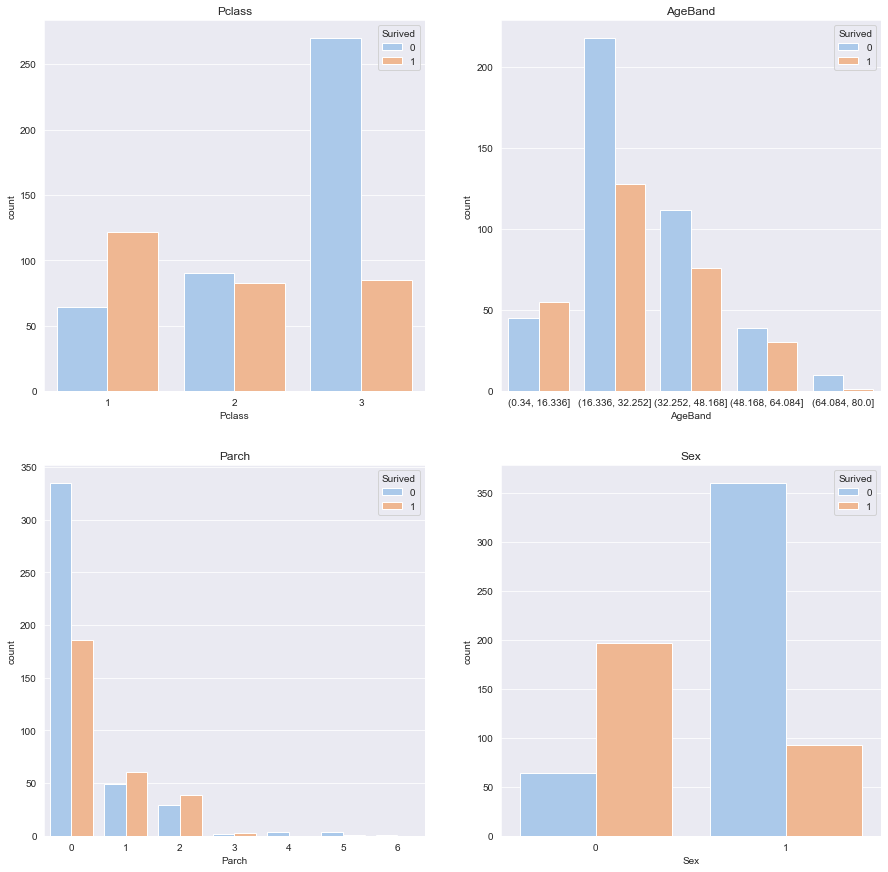

In [20]:
cols = ['Pclass', 'AgeBand', 'Parch','Sex']
n_rows = 2
n_cols = 2
# create a subplot for the different cols
fig, axes = plt.subplots(n_rows, n_cols, figsize = (15,15))

for r in range(0, n_rows):
    for c in range(0, n_cols):
        i = r*n_cols + c #index to go through the number of cols
        ax = axes[r][c] #define each position of the subplot
        sns.countplot(train_df[cols[i]], hue=train_df['Survived'], ax = ax)
        ax.set_title(cols[i])
        ax.legend(title='Surived', loc='upper right')
plt.show()

<AxesSubplot:xlabel='Sex'>

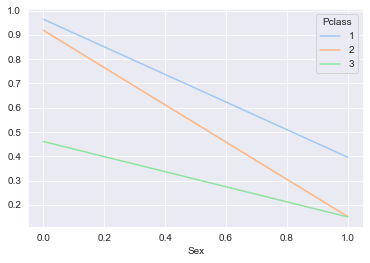

In [21]:
train_df.pivot_table('Survived', index='Sex', columns='Pclass').plot()

# Splitting the data

## Without validation set

In [28]:
X = train_df.iloc[:, 2:5].values
Y_traget = train_df.iloc[:, 1].values
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_traget, 
                                                    train_size=0.75, random_state=400)
print(X_train.shape,X_test.shape,Y_train.shape,Y_test.shape)

(535, 3) (179, 3) (535,) (179,)


In [29]:
def models(X_train, Y_train):
    #logistic regression
    from sklearn.linear_model import LogisticRegression
    log = LogisticRegression(random_state=400)
    log.fit(X_train,Y_train)
    #KNN
    from sklearn.neighbors import KNeighborsClassifier
    KNN = KNeighborsClassifier(n_neighbors=5, metric = 'minkowski', p = 2)
    KNN.fit(X_train,Y_train)
    #support vector classifiers
    from sklearn.svm import SVC
    SVC_lin = SVC(kernel='linear', random_state=400)
    SVC_lin.fit(X_train,Y_train)
    
    SVC_RBF = SVC(kernel='rbf', random_state=400)
    SVC_RBF.fit(X_train,Y_train)
    
    #decision tree
    from sklearn.tree import DecisionTreeClassifier
    tree = DecisionTreeClassifier(criterion='entropy', random_state=400)
    tree.fit(X_train,Y_train)
    
    
    from sklearn.ensemble import RandomForestClassifier
    forest = RandomForestClassifier(n_estimators= 10, criterion='entropy', random_state=400)
    forest.fit(X_train,Y_train)
    
    # print accuracy
    
    print('[0]Logistic regression accuracy: ', log.score(X_train, Y_train))
    print('[1]KNN regression accuracy: ', KNN.score(X_train, Y_train))
    print('[2]SVC_lin regression accuracy: ', SVC_lin.score(X_train, Y_train))
    print('[3]SVC_RBF regression accuracy: ', SVC_RBF.score(X_train, Y_train))
    print('[4]Decision tree regression accuracy: ', tree.score(X_train, Y_train))
    print('[5]Random Forest regression accuracy: ', forest.score(X_train, Y_train))
    return log, KNN, SVC_lin, SVC_RBF, tree, forest



In [30]:
models = models(X_train,Y_train)

[0]Logistic regression accuracy:  0.7869158878504673
[1]KNN regression accuracy:  0.8205607476635514
[2]SVC_lin regression accuracy:  0.7757009345794392
[3]SVC_RBF regression accuracy:  0.6074766355140186
[4]Decision tree regression accuracy:  0.897196261682243
[5]Random Forest regression accuracy:  0.8878504672897196


In [31]:
y_predict = models[0].predict(X_test)
accuracy_score(y_predict, Y_test)

0.8212290502793296

In [32]:
train_scores = cross_val_score(models[0], X_train, Y_train, scoring='accuracy', cv=10)
train_scores
for index, i in enumerate(train_scores):
    print("Fold {}: {}".format(index + 1, i))
print("Mean Fold Score: {}".format(train_scores.mean()))

Fold 1: 0.8518518518518519
Fold 2: 0.7592592592592593
Fold 3: 0.8148148148148148
Fold 4: 0.8148148148148148
Fold 5: 0.7777777777777778
Fold 6: 0.8301886792452831
Fold 7: 0.7547169811320755
Fold 8: 0.7169811320754716
Fold 9: 0.7358490566037735
Fold 10: 0.7924528301886793
Mean Fold Score: 0.7848707197763802


In [33]:
test_scores = cross_val_score(models[0], X_test, Y_test, scoring='accuracy', cv=10)

for index, i in enumerate(test_scores):
    print("Fold {}: {}".format(index + 1, i))
print("Mean Fold Score: {}".format(test_scores.mean()))

Fold 1: 0.8333333333333334
Fold 2: 0.8333333333333334
Fold 3: 0.8333333333333334
Fold 4: 0.8888888888888888
Fold 5: 1.0
Fold 6: 0.8333333333333334
Fold 7: 0.7777777777777778
Fold 8: 0.7777777777777778
Fold 9: 0.7222222222222222
Fold 10: 0.8235294117647058
Mean Fold Score: 0.8323529411764706


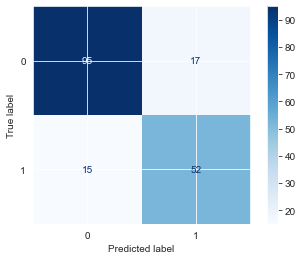

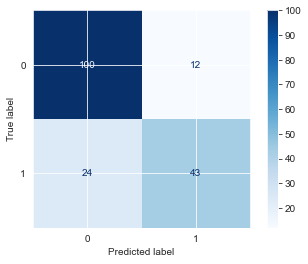

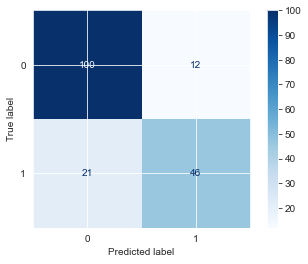

In [39]:
forest_cfm = plot_confusion_matrix(models[0], X_test, Y_test, cmap='Blues', values_format='.3g')
tree_cfm = plot_confusion_matrix(models[4], X_test, Y_test, cmap='Blues', values_format='.3g')
reg_cfm = plot_confusion_matrix(models[5], X_test, Y_test, cmap='Blues', values_format='.3g')

In [35]:
#review the structure of the data used for the model
#the first 5 values in the test dataset 
#test_df.drop(test_df['SibSp'],inplace=True, axis=1)
X = test_df.iloc[:, 1:4]
X

,Pclass,Sex,Age
0,3,1,34.5
1,3,0,47.0
2,2,1,62.0
3,3,1,27.0
4,3,0,22.0
...,...,...,...
409,3,0,3.0
411,1,0,37.0
412,3,0,28.0
414,1,0,39.0


In [37]:
logistic = models[0]
result = logistic.predict(X)
logistic_prediction_df = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Result' : result})
logistic_prediction_df

,PassengerId,Result
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
409,1301,1
411,1303,1
412,1304,1
414,1306,1


In [40]:
Tree = models[4]
result = Tree.predict(X)
tree_prediction_df = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Result' : result})
tree_prediction_df

,PassengerId,Result
0,892,0
1,893,0
2,894,1
3,895,0
4,896,0
...,...,...
409,1301,0
411,1303,1
412,1304,0
414,1306,1


In [41]:
RF = models[4]
result = RF.predict(X)
RF_df = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Result' : result})
RF_df

,PassengerId,Result
0,892,0
1,893,0
2,894,1
3,895,0
4,896,0
...,...,...
409,1301,0
411,1303,1
412,1304,0
414,1306,1


In [42]:
example_output_df

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
